MiDaS comparison

In [80]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import torch
from PIL import Image


In [81]:
IMG_DIR   = "/content/rgb"
DEPTH_DIR = "/content/depth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [82]:
rgb_files = sorted([f for f in os.listdir(IMG_DIR) if f.endswith(".png")])

In [83]:
def load_depth(path):
    d = np.array(Image.open(path)).astype(np.float32)

    if d.ndim == 3 and d.shape[2] == 4:  # RGBA
        # Check if R=G=B=A
        if np.allclose(d[:,:,0], d[:,:,1]) and np.allclose(d[:,:,1], d[:,:,2]):
            d = d[:,:,0]
        else: # Channels differ.
            print(f"RGBA channels differ. Using R channel.") # To act as warning
            d = d[:,:,0]
    elif d.ndim == 3:
        d = d[:,:,0]  # Use first channel if multi-channel

    return d


In [84]:
def align(pred, gt, mask=None):
    """Compute optimal scale+shift, such that aligned = s*pred + b"""
    if mask is None:
        mask = gt > 0

    p = pred[mask].flatten()
    g = gt[mask].flatten()

    # Minimise least square to calculate align shift
    A = np.column_stack([p, np.ones_like(p)])
    x, _ = np.linalg.lstsq(A, g, rcond=None)[:2]
    s, b = x

    return s, b

def compute_metrics(pred, gt, mask=None):
    if mask is None:
        mask = gt > 0

    s, b = align(pred, gt, mask)
    pred_aligned = s * pred + b

    p = pred_aligned[mask].flatten()
    g = gt[mask].flatten()

    # SI-RMSE (Scale-invariant, log space)
    log_p = np.log(np.maximum(p, 1e-8))
    log_g = np.log(np.maximum(g, 1e-8))
    diff = log_p - log_g
    si_rmse = np.sqrt((diff**2).mean() - (diff.mean())**2)

    absrel = np.mean(np.abs(p - g) / np.maximum(g, 1e-8)) #Abs

    # RMSE
    rmse = np.sqrt(np.mean((p - g)**2))

    # Selected threshold: 1.25, can be modified.
    d_threshold = (np.maximum(p / g, g / p) < 1.25).mean()

    return {
        "si_rmse": si_rmse,
        "absrel": absrel,
        "rmse": rmse,
        "delta_1.25": d_threshold,
        "scale": s,
        "shift": b
    }

In [85]:
models = { # Only testing MiDaS here.
    "MiDaS_small": "MiDaS_small",
    "DPT_Hybrid": "DPT_Hybrid",
    "DPT_Large": "DPT_Large"
}

loaded = {}
for name, hub_name in models.items():
    model = torch.hub.load("intel-isl/MiDaS", hub_name).to(device).eval()
    transform = torch.hub.load("intel-isl/MiDaS", "transforms")

    tf = transform.small_transform if hub_name == "MiDaS_small" else transform.dpt_transform
    loaded[name] = (model, tf)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [86]:

results = []

for rgb_img in rgb_files:
    img_num = rgb_img.replace(".png", "")
    rgb = cv2.imread(os.path.join(IMG_DIR, rgb_img))[:, :, ::-1]
    gt = load_depth(os.path.join(DEPTH_DIR, rgb_img))
    gt = np.maximum(gt, 1e-8)

    for model_name, (model, tf) in loaded.items():
        inp = tf(rgb).to(device)
        with torch.no_grad():
            pred = model(inp).cpu().numpy()[0]

        H, W = gt.shape
        pred_resized = cv2.resize(pred, (W, H), interpolation=cv2.INTER_CUBIC)
        pred_resized = np.maximum(pred_resized, 1e-8)

        metrics = compute_metrics(pred_resized, gt)

        res = {"imgTag": img_num, "model": model_name, **metrics}
        results.append(res)

df = pd.DataFrame(results)
df

,imgTag,model,si_rmse,absrel,rmse,delta_1.25,scale,shift
0,00,MiDaS_small,0.389726,0.312696,54.632492,0.738062,-0.106305,273.281494
1,00,DPT_Hybrid,0.373352,0.289776,52.031429,0.687460,-0.052555,274.126312
2,00,DPT_Large,0.376341,0.290463,52.668694,0.682956,-3.530344,264.975464
3,03,MiDaS_small,0.105915,0.057817,21.802124,0.939074,-0.027967,259.153839
4,03,DPT_Hybrid,0.104995,0.057602,21.617975,0.939174,-0.012743,257.962036
5,03,DPT_Large,0.105649,0.057590,21.754385,0.938636,-1.077107,257.199341
6,08,MiDaS_small,0.122616,0.084921,26.108303,0.877750,-0.018297,252.768692
7,08,DPT_Hybrid,0.101561,0.075587,21.757921,0.922054,-0.088928,285.824554
8,08,DPT_Large,0.116354,0.076622,24.758806,0.884805,-1.780310,259.363892
9,12,MiDaS_small,0.145835,0.088150,28.680836,0.908303,-0.031394,257.630280


In [87]:
summary = df.groupby("model")[["si_rmse", "absrel", "rmse", "delta_1.25"]].agg(["mean", "std"])
summary

si_rmse              absrel                 rmse             \
                 mean       std      mean       std       mean        std   
model                                                                       
DPT_Hybrid   0.144198  0.138403  0.101552  0.110257  24.627743  18.588112   
DPT_Large    0.146594  0.138711  0.101998  0.110471  25.135370  18.715328   
MiDaS_small  0.152852  0.143691  0.108718  0.119379  26.253216  19.481531   

            delta_1.25            
                  mean       std  
model                             
DPT_Hybrid    0.891813  0.119338  
DPT_Large     0.884024  0.120150  
MiDaS_small   0.892638  0.097524

Visualisation

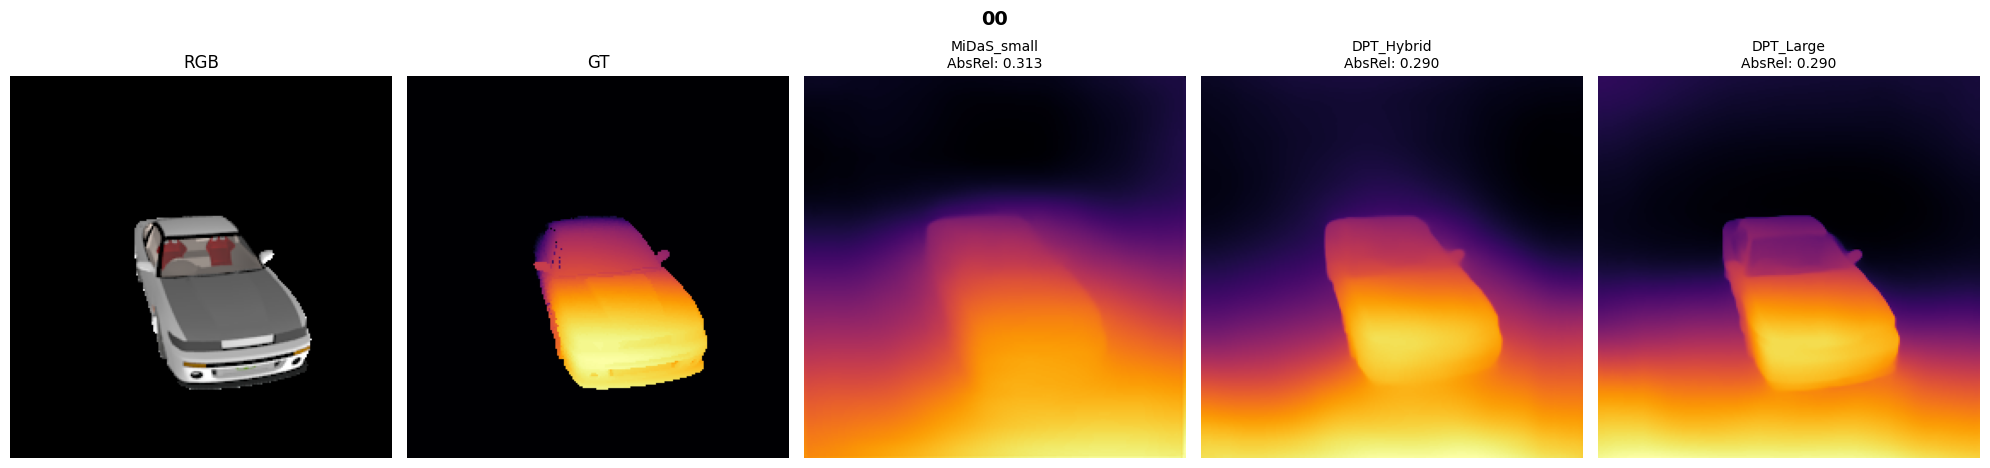

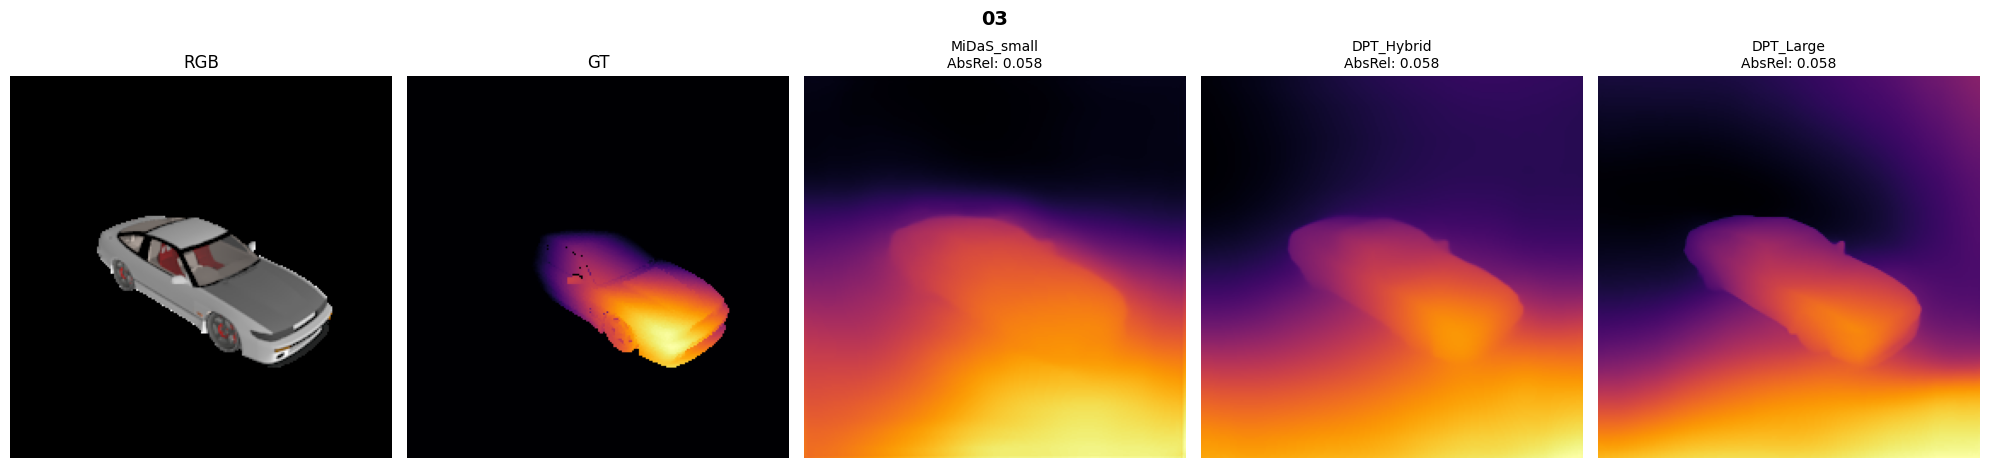

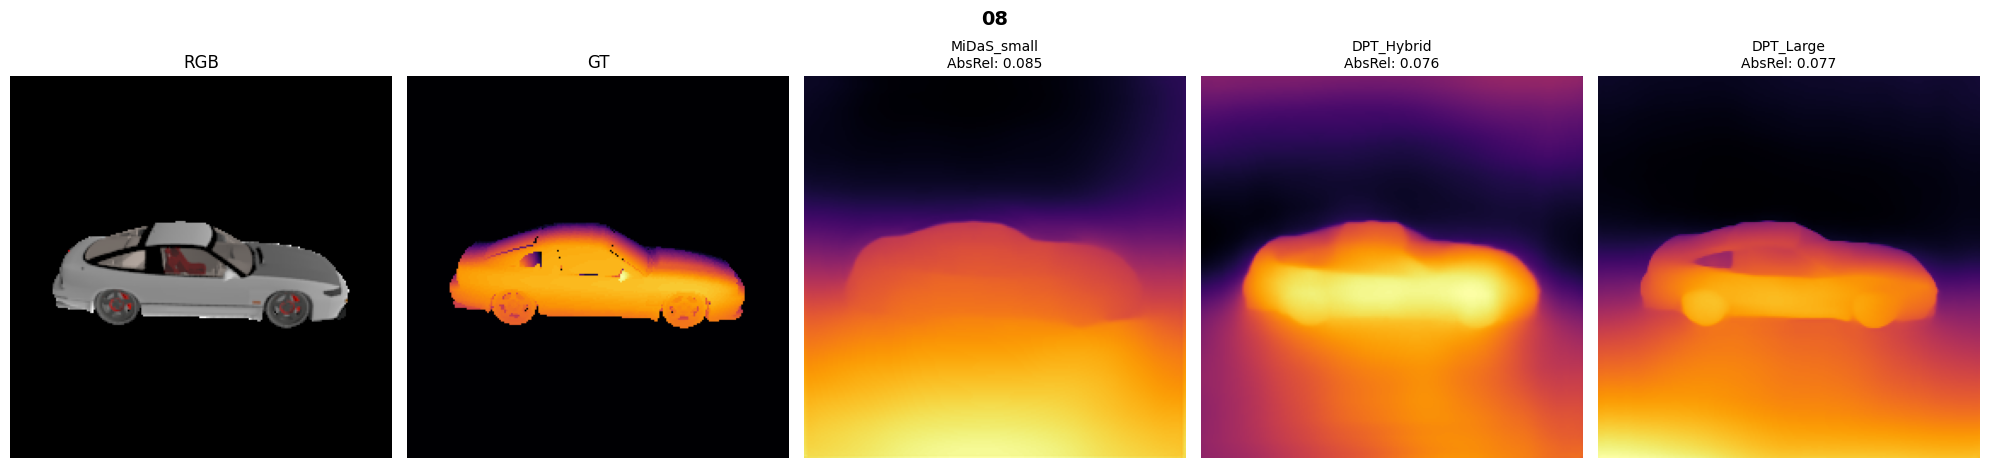

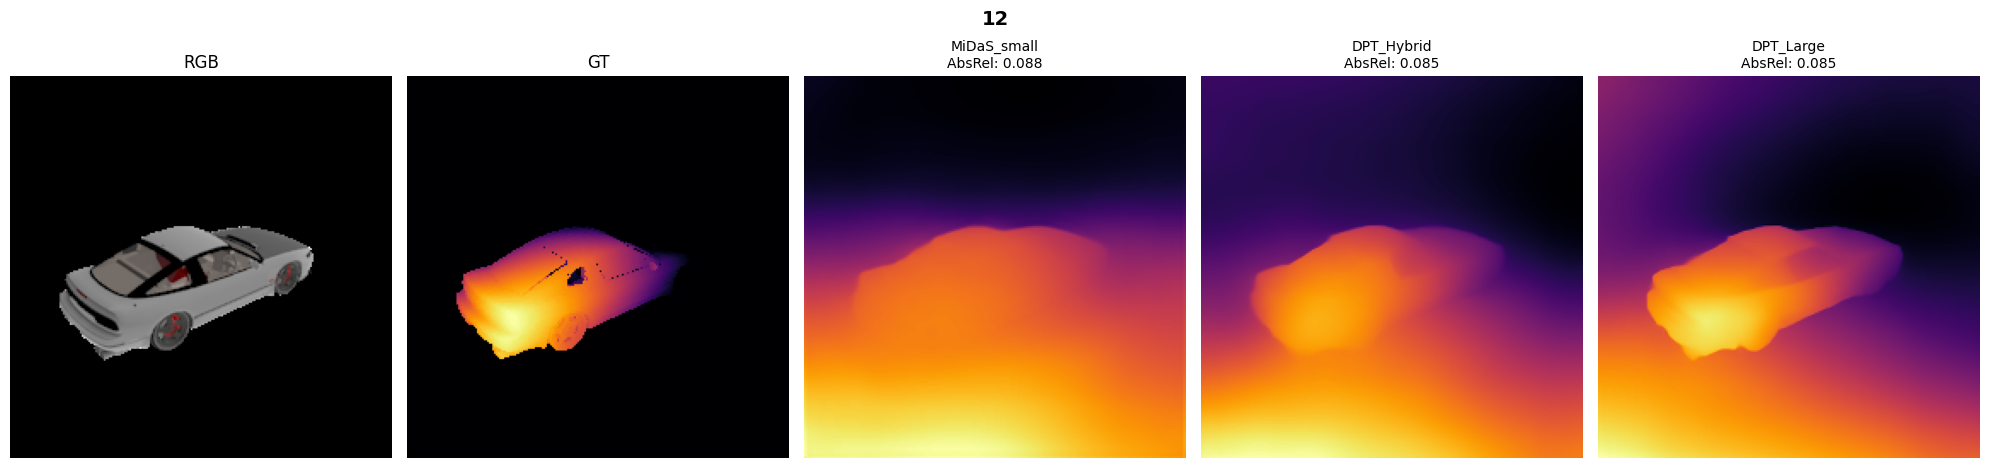

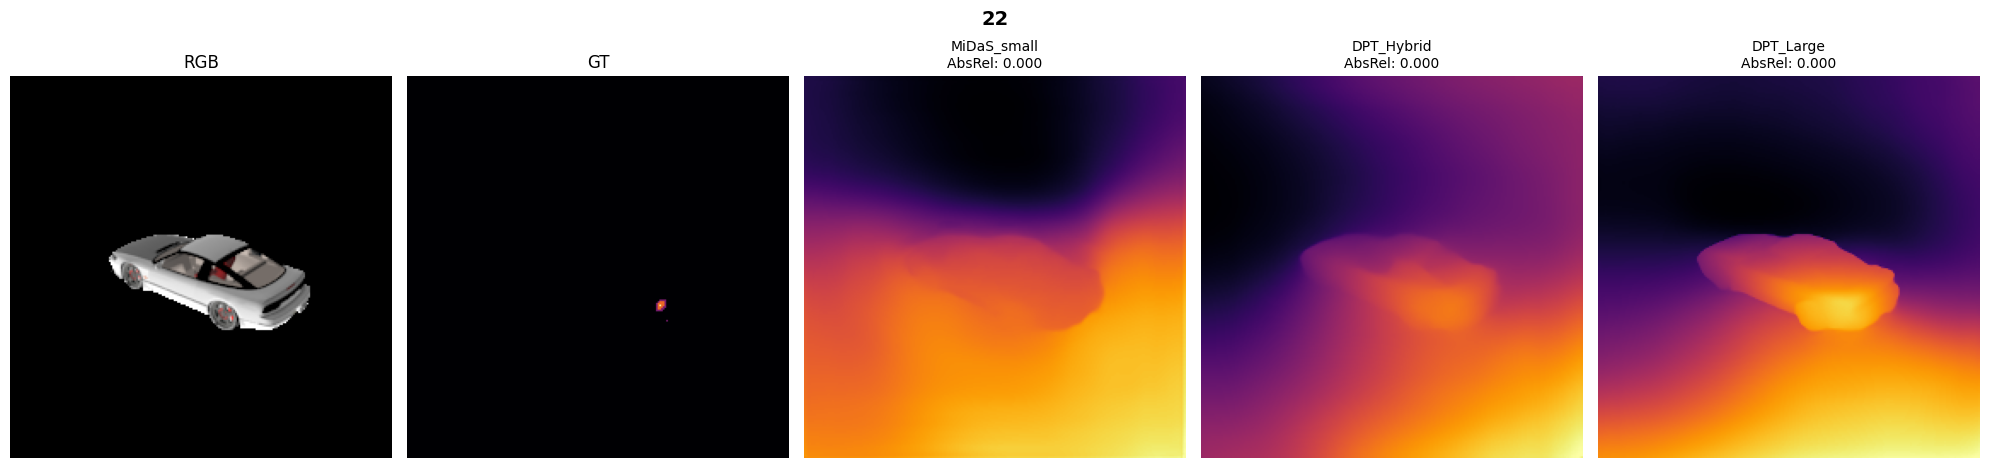

In [88]:
INVERT_GT = True # Ground truth map appears as inverse of the MiDaS-produced maps.
model_order = ["MiDaS_small", "DPT_Hybrid", "DPT_Large"]

for rgb_img in rgb_files:
    img_num = rgb_img.replace(".png", "")
    rgb = cv2.imread(os.path.join(IMG_DIR, rgb_img))[:, :, ::-1]
    gt = load_depth(os.path.join(DEPTH_DIR, rgb_img))

    # Normalised only for visualisation - to match the MiDaS convention
    gt_vis = (gt - gt.min()) / (gt.max() - gt.min() + 1e-8)
    if INVERT_GT:
        gt_vis = 1 - gt_vis

    H, W = gt_vis.shape
    N = 2 + len(model_order)
    fig, axes = plt.subplots(1, N, figsize=(4*N, 5))
    fig.suptitle(f"{img_num}", fontsize=14, fontweight="bold")

    axes[0].imshow(rgb)
    axes[0].set_title("RGB")
    axes[0].axis("off")

    axes[1].imshow(gt_vis, cmap="inferno")
    axes[1].set_title("GT") # Ground Truth - Dataset provided.
    axes[1].axis("off")

    for i, model_name in enumerate(model_order, start=2):
        row = df[(df["imgTag"] == img_num) & (df["model"] == model_name)].iloc[0]

        inp = cv2.imread(os.path.join(IMG_DIR, rgb_img))[:, :, ::-1]
        model, tf = loaded[model_name]
        with torch.no_grad():
            pred = model(tf(inp).to(device)).cpu().numpy()[0]

        pred = cv2.resize(pred, (W, H), interpolation=cv2.INTER_CUBIC)
        pred_vis = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)

        axes[i].imshow(pred_vis, cmap="inferno")
        axes[i].set_title(f"{model_name}\nAbsRel: {row['absrel']:.3f}", fontsize=10)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()